In [1]:
import matplotlib.pyplot as plt
import numpy as np

def filter(seuil):
    def filter_decorator(f):
        def new_func(y):
            if (y) < seuil: return seuil
            return f(y)
        return new_func
    return filter_decorator

@filter(10)
def bof(y):
    return y

print(bof(-2))
print(bof(850))

10
850


In [2]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __add__(self, other):
        return Point(self.x + other.x, self.y + other.y)

    def __rmul__(self, k):
        return Point(self.x * k, self.y * k)

    def __sub__(self, other):
        return Point(self.x - other.x, self.y - other.y)

    def distance(self, point):
        somme = (point.x - self.x)**2 + (point.y - self.y)**2
        return np.abs(np.sqrt(somme))

    def __truediv__(self, k):
        return Point(self.x / k, self.y / k)

    def __repr__(self):
        return "(x : " + str(self.x) + " y: " + str(self.y) + ")"

    def __lt__(self, other):
        return np.array((self.x, self.y)) < np.array((other.x, other.y))

    def __iter__(self):
        return iter([self.x, self.y])

    def plot(self, t):
        plt.plot(self.x, self.y, t)

In [3]:
class Groupe:
    def __init__(self, points=None):
        if points is None:
            points = np.array([])
        self.points = np.array(points)

    def __iter__(self):
        return iter(self.points)

    def __repr__(self):
        return str(self.points)

    def __len__(self):
        return len(self.points)

    def add_point(self, point):
        self.points = np.array(list(self.points) + [point])

    def remove_point(self, point):
        indice_point = next(i for i in range(self.points) if self.points[i] == point)
        np.delete(self.points(indice_point))

    def vider(self):
        self.points = np.array([])

    def get_points(self):
        return np.array(self.points, copy=True)

    def get_centre(self):
        """
        mx = 1/len(self) * np.array([p.x for p in self]).sum()
        my = 1/len(self) * np.array([p.y for p in self]).sum()
        return Point(mx, my)
        """
        return np.mean(self.points)

    def simulation_centre(self, point):
        points = np.array(list(self.points) + [point])
        return np.mean(points)

    def plot(self, t):
        #plt.plot([point.x for point in self], [point.y for point in self], t)
        for point in self.points:
            point.plot(t)

In [4]:
def afficher_premiers_centres(k, groupes, centres, size):
    plt.figure()
    plt.title("Choix des premiers centres")
    plt.xlim(0,size)
    plt.ylim(0,size)

    for i in range(k):
        groupes[i].plot("bo")
        centres[i].plot("rx")

    plt.show()

In [5]:
def blob(n, x=0.5, y=0.5, scale=0.5):
    r = np.random.random(n) * scale
    teta = np.random.random(n) * 2 * np.pi
    xs = x + r * np.cos(teta)
    ys = y + r * np.sin(teta)
    return Groupe(np.array([Point(xs[i], ys[i]) for i in range(n)]))

In [6]:
def get_all_points(groupes):
    points = []
    for groupe in groupes:
        for point in groupe.get_points():
            points.append(point)
        groupe.vider()
    return points

In [7]:
def initialisation_centre(k, groupes, points):
    centres = []
    for i in range(k):
        indice = int(np.random.random() * len(points))
        centres.append(points[indice])
        # On ajoute le point au groupe pour éviter de le perdre
        groupes[i].add_point(points[indice])
        del points[indice]
    return centres

In [8]:
def maj_groupes(k, groupes, centres, points):
    for point in points:
        # On récupère la distance du point à chaque centre
        differences = [difference for difference in (centres[i].distance(point) for i in range(k))]

        # On récupère le centre qui a la distance la plus courte avec le point
        indice_min = next(i for i in range(len(differences)) if differences[i] == min(differences))

        # Ajout du point dans le groupe le plus proche
        groupes[indice_min].add_point(point)

In [9]:
def get_centres(k, groupes):
    return [centre for centre in (groupes[i].get_centre() for i in range(k))]

In [10]:
def afficher_premiere_etape(k, groupes, size, couleurs):
    plt.figure()
    plt.title("Première étape")
    plt.xlim(0,size)
    plt.ylim(0,size)

    # Récupération des centres
    centres = get_centres(k, groupes)

    for i in range(k):
        groupes[i].plot(couleurs[i] + "o")
        centres[i].plot("rx")

    plt.show()

In [11]:
def afficher_depart(k, groupes, size, couleurs):
    plt.figure()
    plt.title("Départ")
    plt.xlim(0,size)
    plt.ylim(0,size)

    for i in range(k):
        groupes[i].plot(couleurs[i] + "o")
        groupes[i].get_centre().plot("rx")

    plt.show()

In [12]:
def afficher_etape(k, groupes, size, numero_etape, couleurs):
    plt.figure()
    plt.title("Étape " +  str(numero_etape))
    plt.xlim(0,size)
    plt.ylim(0,size)

    # Récupération des centres
    centres = get_centres(k, groupes)

    for i in range(k):
        groupes[i].plot(couleurs[i] + "o")
        centres[i].plot("rx")

    plt.show()


In [13]:
def init(k, groupes, centres, size, n):
    for i in range(k):
        centres.append(Point(np.random.random() * size, np.random.random() * size))
        groupes.append(blob(n, centres[i].x, centres[i].y, 0.1))

In [14]:
def premiere_etape(k, groupes, points, size):
    centres = initialisation_centre(k, groupes, points)

    afficher_premiers_centres(k, groupes, centres, size)

    # Calcul des nouveaux groupes en fonction des points les plus proche des centres
    maj_groupes(k, groupes, centres, points)
    return centres

In [15]:
def deuxieme_etape(k, groupes, centres, ratio, couleurs, size):
    numero_etape = 2
    negligeable = False
    while not negligeable:

        # On récupère tous les points et vide les groupes pour les refaire
        points = get_all_points(groupes)

        maj_groupes(k, groupes, centres, points)

        # Calcul des nouveau centres pour vérifier si on converge
        nouveau_centres = get_centres(k, groupes)
        negligeables = [nouveau_centres[i].distance(centres[i]) <= ratio for i in range(k)]
        centres = nouveau_centres

        negligeable = True
        for i in range(len(negligeables)):
            if not negligeables[i]:
                negligeable = False
                break
        afficher_etape(k, groupes, size, numero_etape, couleurs)
        numero_etape += 1

In [16]:
def k_means(k, groupes, size, couleurs):

    # Affichage des données à analyser
    afficher_depart(k, groupes, size, couleurs)

    # On récupère tous les points et vide les groupes pour les refaire
    points = get_all_points(groupes)

    # Première étape, initialisation des centres et des groupes
    centres = premiere_etape(k, groupes, points, size)

    afficher_premiere_etape(k, groupes, size, couleurs)


    # Deuxième étape, boucler jusqu'à la convergence
    ratio = 0.01
    deuxieme_etape(k, groupes, centres, ratio, couleurs, size)

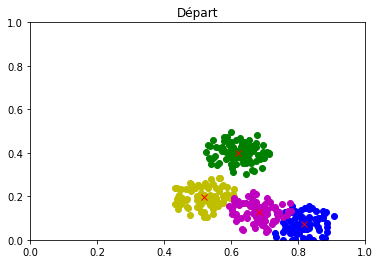

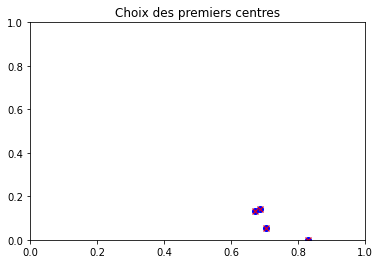

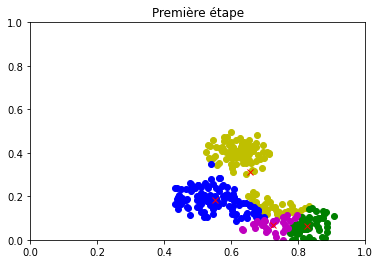

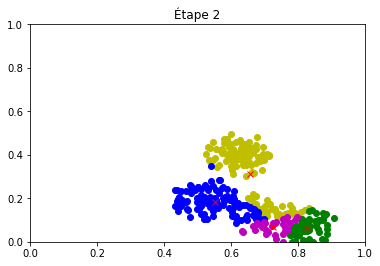

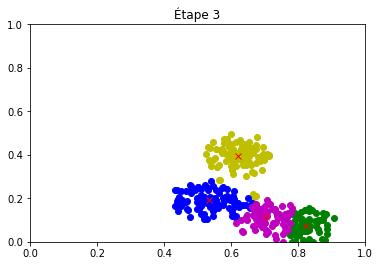

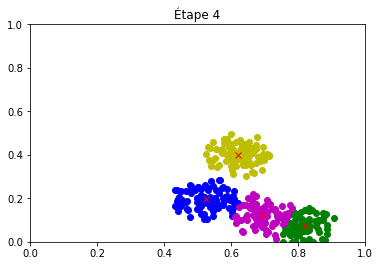

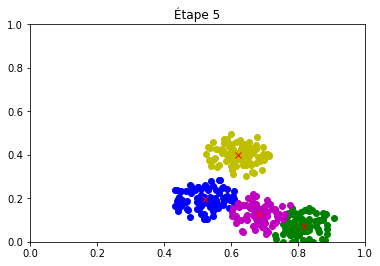

NameError: name 'groupe' is not defined

In [17]:
k = 4
size = 1
n = 100
centres = []
groupes = []
couleurs = ("y", "g", "b", "m", "c", "k")

# Création des données de départ à analyser
init(k, groupes, centres, size, n)
k_means(k, groupes, size, couleurs)
print(list(groupe))

In [ ]:
data = np.genfromtxt('iris.txt', dtype=None,delimiter=',',names=True,encoding="utf8")

In [ ]:
class Classe(Groupe):
    def __init__(self, couleur, fleurs=None):
        super().__init__(fleurs)
        self.couleur = couleur

    def get_fleurs(self):
        return self.points

In [ ]:
class Fleur(Point):
    def __init__(self, nom, car1, car2):
        super().__init__(car1, car2)
        self.nom = nom

    def get_car1(self):
        return self.x

    def get_car2(self):
        return self.y

In [ ]:
def get_classes(data, c1, c2, noms, couleurs):
    classes = {}
    for i, nom in enumerate(noms):
        fleurs = data[data["classe"] == nom]
        classes[nom] = Classe(couleurs[i], [Fleur(nom, fleur[c1], fleur[c2]) for fleur in fleurs])
    return classes

def plot_classes(classes):
    for key, value in classes.items():
        value.plot(value.couleur + "o")

    """ Ne fonctionne pas ?
    return max([car1 for car1 in [fleur.get_car1() for fleur in [fleurs for fleurs in fleurss]]]), \
           max([car2 for car2 in [fleur.get_car2() for fleur in [fleurs for fleurs in fleurss]]])
    """

    fleurss = [classe.get_fleurs() for classe in classes.values()]
    x = y = 0

    for fleurs in fleurss:
        tmp = max([car for car in [fleur.get_car1() for fleur in fleurs]])
        if x < tmp: x = tmp;
        tmp = max([car for car in [fleur.get_car2() for fleur in fleurs]])
        if y < tmp: y = tmp;
    return x, y


    # Retourne les valeurs max pour avoir la longueur des axes

noms = ("Iris-setosa", "Iris-versicolor", "Iris-virginica")
couleurs = ("y", "r", "g")
classes = get_classes(data, 3, 0, noms, couleurs)


plt.figure()
plt.title("Modèles")

plot_classes(classes)

plt.show()

In [ ]:
k_means(3, classes, 8, couleurs)